In [1]:
# %cd Mask_RCNN/
# !python setup.py install
# %cd ..

In [2]:
# import tensorflow as tf
# tf.__version__`
# 파이썬 파일에 들어가서 사물명(rain) 수정
# 65 , 93, 138, 153, 173 번째 줄
# 모르겠으면 py파일을 pycharm이나 VisualStudio로 열어서 ctrl+f로 찾도록...

In [3]:
import time
#그리기 전 지시사항 전달
instr = """지시사항

1) 용지에 빗속의 사람을 그리세요.
2) 만화나 막대기 같은 사람이 아닌 완전한 사람을 그리세요.
3) 그림을 그릴 때는 옆 사람의 그림을 보고 그리거나, 서로 의논하여 그리지 않고 혼자서 생각대로 자유롭게 그리세요.
"""

print(instr)
for x in range(3):
    time.sleep(1)
    print(".", end="")

지시사항

1) 용지에 빗속의 사람을 그리세요.
2) 만화나 막대기 같은 사람이 아닌 완전한 사람을 그리세요.
3) 그림을 그릴 때는 옆 사람의 그림을 보고 그리거나, 서로 의논하여 그리지 않고 혼자서 생각대로 자유롭게 그리세요.

...

In [4]:
# 그림 완료 후 추가질문

print("\n")
print("그림 그리기가 완료되었다면, 다음의 질문에 차례대로 답해주시기 바랍니다.")

time.sleep(2)

q1 = input("1) 비는 얼마만큼 내리나요? : \n(많이, 보통, 적게)")
q2 = input("2) 비에 얼마나 맞고 있나요?: \n(많이, 조금, 없음) ")
q3 = input("3) 그 사람의 기분은 어떻습니까? \n(좋다, 그저그렇다, 나쁘다) : ")

# 답변내용 저장 
answer_result = [q1,q2,q3]



그림 그리기가 완료되었다면, 다음의 질문에 차례대로 답해주시기 바랍니다.
1) 비는 얼마만큼 내리나요? : 
(많이, 보통, 적게)보통
2) 비에 얼마나 맞고 있나요?: 
(많이, 조금, 없음) 조금
3) 그 사람의 기분은 어떻습니까? 
(좋다, 그저그렇다, 나쁘다) : 나쁘다


In [5]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

# Root directory of the project
# ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
# sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

# 예측 모델 임포트
import umbrella.umbrella as umbrella
import cloud.cloud as cloud
import person.person as person
import puddle.puddle as puddle
import thunder.thunder as thunder
%matplotlib inline 

# MODEL_DIR = os.path.join("logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join("mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


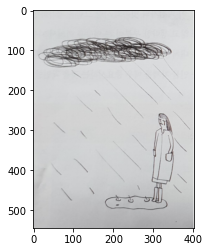

In [8]:
IMAGE_DIR = "예시.PNG"
image = Image.open(os.path.join(IMAGE_DIR)).convert('RGB')
image = np.array(image)
y,x,_ = image.shape
plt.imshow(image)

In [9]:
def Custom_predict(custom,custom_name, IMAGE): # predict 모델을 만드는 것 
    
    config = custom.CustomConfig()
    
    class InferenceConfig(config.__class__):
    # Run detection on one image at a time
        GPU_COUNT = 1
        IMAGES_PER_GPU = 1
    config = InferenceConfig()
    TEST_MODE = "inference"
    DEVICE = "/cpu:0" 
    with tf.device(DEVICE):
        model = modellib.MaskRCNN(mode="inference", model_dir="",
                                  config=config)
    class_names = [custom_name]
    weights_path = custom_name+'.h5' # 우리가 한 학습폴더를 불러와서 
    model.load_weights(weights_path, by_name=True)
    
    results = model.detect([image], verbose=0)
    r = results[0]
    r["class_names"] = ["",custom_name]  # 딕셔너리에 추가적으로 커스텀 네임을 입력할 수 있도록 만들어 줬다 
    return r

In [ ]:
person_result = Custom_predict(person,'person',image)
cloud_result = Custom_predict(cloud,'cloud',image)
umbrella_result = Custom_predict(umbrella,'umbrella',image)
puddle_result = Custom_predict(puddle,'puddle',image)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


# 위치와 크기 정보를 나타내는 함수

In [ ]:
def status(result, image):
    # 객체가 없으면 없음으로 반환
    if not len(result["class_ids"]):
        return "없음"
    elif len(result["class_ids"])>1:
        return "2개 이상"
    
    mask = result["masks"]
    
    status = {}
    
    y_min , y_max , x_min, x_max = y_x(mask)
    
    y_cen = (y_min+y_max)/2
    x_cen = (x_min+x_max)/2
    status["위치"] = position(y_cen, x_cen)
        
    status["크기"] = size(y_min, y_max , x_min,x_max)
    
    return status

def position(y_cen,x_cen):
    
    y,x,_ = image.shape
    position = []
    if x_cen>x*2/3:
        position.append("오른쪽")
    elif x_cen>x*1/3:
        position.append("가운데")
    else:
        position.append("왼쪽")
    if y_cen>y*2/3:
        position.append("아래")
    elif y_cen>y*1/3:
        position.append("가운데")
    else:
        position.append("위")
    return position

def size(y_min, y_max , x_min,x_max):
    y,x,_ = image.shape
    y_size = y_max-y_min
    x_size  = x_max-x_min
    
    if y_size*x_size>(y*x)/8:
        return "크다"
    elif y_size*x_size>(y*x)/16:
        return "보통"
    else :
        return "작다"
    
def y_x(mask):
    y_min = np.where(mask)[0].min()
    y_max = np.where(mask)[0].max()
    x_min = np.where(mask)[1].min()
    x_max= np.where(mask)[1].max()
    return y_min , y_max , x_min, x_max

# 위치와 크기 정보출력

# 스트레스 점수 산출 함수들

In [ ]:
# 비의 양
def S1(answer):
    if answer =="많이":
        return 3
    elif answer == "보통":
        return 2
    return 1
# 비와 사람의 접촉
def S5(answer) : 
    if answer =="많이 접촉":
        return 3
    elif answer =="조금 접촉":
        return 2
    return 1
# 구름의 수 
def S7(cloud_result):
    num = len(cloud_result["class_ids"])
    if num==0:
        return 1
    elif num<3:
        return 2
    return 3
# 구름의 면적
def S8(cloud_result):
    if not len(cloud_result):
        return 1
    large = 0
    for i in range(len(cloud_result["class_ids"])):
        _,_,a,b = y_x(cloud_result["masks"][:,:,i])
        large+=(b-a)
    if large<x/10:
        return 1
    elif large<x/5:
        return 2
    return 3

# 웅덩이 수 
        
def S12(puddle_result):
    if not len(puddle_result):
        return 1 
    elif len(puddle_result)<3:
        return 2
    else :
        return 3
# 웅덩이 면적    
def S13(puddle_result):
    if not len(puddle_result):
        return 1
    large = 0
    for i in range(len(puddle_result["class_ids"])):
        _,_,a,b = y_x(puddle_result["masks"][:,:,i])
        large+=(b-a)
    if large<x/10:
        return 1
    elif large<x/5:
        return 2
    return 3
# 사람과 웅덩이 관계
def S14(puddle_result, person_result):
    if not len(puddle_result["class_ids"]):
        return 1 
    person_yx  = y_x(person_result["masks"])
    for i in range(len(puddle_result["class_ids"])):
        yx = y_x(puddle_result["masks"][:,:,i])
        
    if yx[2]<person_yx[2]<yx[3] or yx[2]<person_yx[3]<yx[3]:
        return 3
    
    return 2            

# 자원 점수 산출 함수들

In [ ]:
# 직접보호물 개수
def R1(umbrella_result):
    if not len(umbrella_result["class_ids"]):
        return 1
    elif len(umbrella_result["class_ids"]) == 1:
        return 2
    return 3
# 보호물의 적절성
def R4(umbrella_result, person_result):
    
    if (not len(umbrella_result["class_ids"])) or (not len(person_result["class_ids"])):
        return 1
    else:
        umbrella_y_min = y_x(umbrella_result['masks'])[0]
        person_y_min = y_x(person_result['masks'])[0]
        # 우산이 사람위에서 비를 막아주는 경우
        if umbrella_y_min <= person_y_min:
            return 3
        else:
            return 2
# 대상의 기분  
def R7(answer): 
    if answer =="좋다":
        return 3
    elif answer =="그저그렇다":
        return 2
    return 1
# 인물의 크기
def R8(person_result):
    y,x,_ = image.shape
    a ,b,c,d= y_x(person_result["masks"])

   
    if  size(a,b,c,d) == "크다":
        return 3
    elif size(a,b,c,d)  == "보통":
        return 2
    return 1
# 인물의 위치
def R9(person_result):
    y,x,_ = image.shape
    y_min, y_max, x_min, x_max = y_x(person_result['masks'])
    y_cen = (y_min+y_max)/2
    x_cen = (x_min+x_max)/2
    
    # 가운데
    if ((x_cen > x*1/5) and (x_cen < x*1/5)) and ((y_cen > y*1/5) and (y_cen < y*1/5)):
        return 3
    # 중심이탈
    elif ((x_cen > x*1/5) or (x_cen < x*1/5)) and ((y_cen > y*1/5) and (y_cen < y*1/5)):
        return 2
    else:
        return 1

# 스트레스와 자원 점수합산

In [ ]:
def StressScore(image):

    score =0
    score+= S1(answer_result[0])
    score+= S5(answer_result[1])
    score+= S7(cloud_result)
    score+= S8(cloud_result)
    score+= S12(puddle_result)
    score+= S13(puddle_result)
    score+= S14(puddle_result , person_result)
    return score

def ResourceScore(image):
    score=0
    score+= R1(umbrella_result)
    score+= R4(umbrella_result, person_result)
    score+= R7(answer_result[2])
    score+= R8(person_result)
    score+= R9(person_result)  

    return score

# 최종 출력 함수 
# IMAGE_DIR 입력하면 PITR 점수 산출

In [ ]:
def PITRScore(image):
      
    return ResourceScore(image) - StressScore(image) + 3

In [ ]:
PITRScore(image)

# Mask된 이미지 출력하기

In [ ]:
def get_ax(rows=1, cols=1, size=16):
    
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    
    return ax

def Custom_Mask(r1,r2,r3,r4, IMAGE):
    # Load validation dataset
    
    ax = get_ax(1)
    class_names = ["","custom"]
    #Must call before using the dataset
    
    visualize.display_instances(image, r1["rois"], r1['masks'], r1['class_ids'], 
                            r1["class_names"], r1['scores'], ax=ax,
                            title="Predictions")
    visualize.display_instances(image, r2["rois"], r2['masks'], r2['class_ids'], 
                            r2["class_names"], r2['scores'], ax=ax,
                            title="Predictions")
    visualize.display_instances(image, r3["rois"], r3['masks'], r3['class_ids'], 
                            r3["class_names"], r3['scores'], ax=ax,
                            title="Predictions")
    visualize.display_instances(image, r4["rois"], r4['masks'], r4['class_ids'], 
                            r4["class_names"], r4['scores'], ax=ax,
                            title="Predictions")

In [ ]:
Custom_Mask(cloud_result,umbrella_result,puddle_result,person_result, image)

In [ ]:
# 코멘트 내용 정리

Final_Report = """<최종 결과 보고서>

- 그림 내용 해석

비는 '스트레스'를 가늠하는 지표로 빗줄기의 양은 스트레스의 양을 나타냅니다. 
그림 속에 비가 없거나 빗물이 아주 적은 경우는 내담자가 스트레스에 무딘 경우라는 것을 나타내고, 
반대로 빗줄기의 양이 많다면 받고 있는 스트레스의 크기도 그만큼 많다는 것을 나타냅니다 

비에 대한 대응은 스트레스에 대한 대응을 뜻하고 우산을 쓰거나 간접적인 보호물(나무, 집 등) 아래에 숨어
비에 맞지 않고 있다면 내담자가 스트레스에 적절히 대응하고 있다고 볼 수 있습니다.  
그러나 우산이 지나치게 클 경우 스트레스에 대처하는데 과도한 에너지를 사용한다고 볼 수 있습니다.

한편, 그림 속 사람의 크기는 자신의 자아에 대한 크기를 나타냅니다. 
가로등을 그린 경우, 애정과 지지에 대한 관심을 드러낸다고 볼 수 있습니다. 

만약 천둥이나 번개를 그릴 경우, 지금 상당한 스트레스에 직면해 있음을 나타냅니다.

*****************************************************************************************************"""

doc1 = '''현재 자신이 가진 스트레스에 대해 적절하게 대처하고 있습니다.
스트레스 점수가 높더라도 대처능력 점수가 높다면, 그만큼 본인이 스트레스에 대처하는 능력이 좋다고 볼 수 있습니다.
대처능력이 좋은 편이기 때문에 스트레스를 받는 일이 많아도 금방 잘 이겨내는 경우가 많습니다.
스트레스 상황이 생겼을 때 이를 회피하지 않고 문제에 부딪혀 이를 해결하려는 의지력도 가지고 있습니다.
자신의 미래를 낙관적으로 생각하는 경향이 있고, 자신에게 주어진 일을 성공적으로 수행할 수 있다는 믿음을 가리키는 '자기 효능감'이 높은 편입니다.
자신만의 스트레스 극복 & 해소 방법을 주변 사람들에게 공유해주는 것은 어떨까요?'''

doc2 = '''현재 자신이 가진 스트레스에 대해 적절하게 대처하지 못하고 있습니다.
주변의 스트레스들에 비해 그에 대처할 수 있는 자원이 부족한 상황입니다.
대처자원이 부족하다 보니, 자신에게 스트레스 주는 일이 많다면 이를 잘 이겨내지 못하고 위축되거나 불안해하는 경향을 보입니다.
이러한 상황이 계속된다면 우울증에 빠질 수도 있으니 주의해야 합니다.
평소에 본인이 스트레스를 받을 때 대처할 수 있는 여러 방법들을 찾고, 개발하려는 노력이 필요합니다.'''

doc3 = '''스트레스가 높은 집단을 대상으로 점수를 측정했을 때, 대처능력의 평균점수는 –5점 정도로 나옵니다.
현재 본인의 대처능력점수는 -5점 이하로,겪고 있는 스트레스의 양이 상당히 많다고 해석될 수 있습니다.
많은 스트레스에 대해 적절하게 대처하지 못하고 있다는 뜻도 있겠지요.
이러한 상태가 오랜 기간 지속되었을 경우, 마음의 병이 생길 수 있습니다.
따라서 실제로 많은 스트레스로 인해 힘든 상황이라면, 까운 상담소나 병원에 찾아가 상담을 받아 보는 것이 좋겠습니다.'''

doc4 = '''현재 자신이 받는 스트레스와 대처자원의 정도가 균형을 이루고 있는 상태입니다.
언뜻 보면 문제가 없는 상태로 보일 수 있지만, 현재 상황에서 스트레스가 조금만 더 많아진다면 언제든지 스트레스로 인해 힘들어질 수 있습니다.
평소에 어떤 방식으로 스트레스를 해소하는 것이 좋은지에 대해 스스로를 잘 관찰하고, 준비해두는 것이 좋겠습니다.'''

In [ ]:
# 해석결과 출력함수 정의
def print_report(image):
    pitr_score = PITRScore(image)
    stress_score = StressScore(image)
    resource_score = ResourceScore(image)
    
    print(Final_Report, end="\n\n")
    print("- 대처능력점수 해석", end="\n\n")
    print('나의 스트레스 점수는 {}점이고, 자원 점수는 {}점이며 대처능력점수는 {}점입니다.'.format(stress_score,resource_score,pitr_score), end="\n\n")
    
    if pitr_score > 0:
        print(doc1)
    elif pitr_score < 0:
        print(doc2)
        if pitr_score <= -5:
            print("\n")
            print(doc3)
    else:
        print(doc4)

In [ ]:
print_report(image)